In [1]:
import pandas as pd
import time
import random
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from ray.tune.function_runner import StatusReporter
import tensorflow_addons as tfa
from tensorflow.python.keras.optimizers import Adam, sgd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
import kr_helper_funcs as kr
from tensorflow.keras.callbacks import EarlyStopping

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
data_info = pd.read_csv('lending_club_info.csv', index_col='LoanStatNew')

print(data_info.loc['revol_util']['Description'])

def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

feat_info('mort_acc')


df = pd.read_csv('lending_club_loan_two.csv')
df.info()

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
Number of mortgage accounts.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan

(0.0, 45000.0)

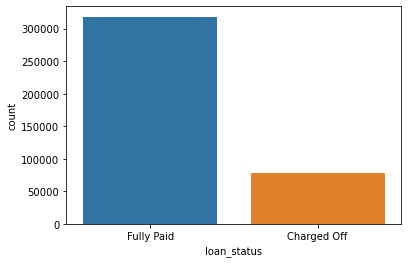

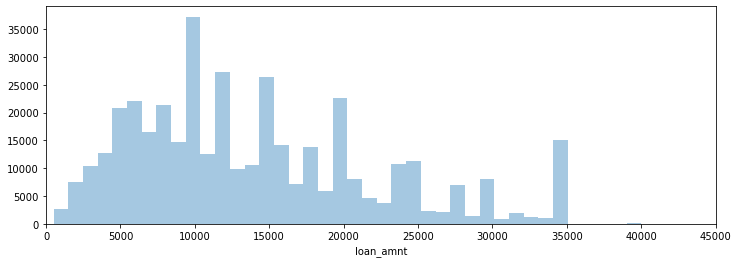

In [3]:
sns.countplot(x='loan_status',data=df)
plt.figure(figsize=(12,4))
sns.distplot(df['loan_amnt'],kde=False,bins=40)
plt.xlim(0,45000)

(10.0, 0.0)

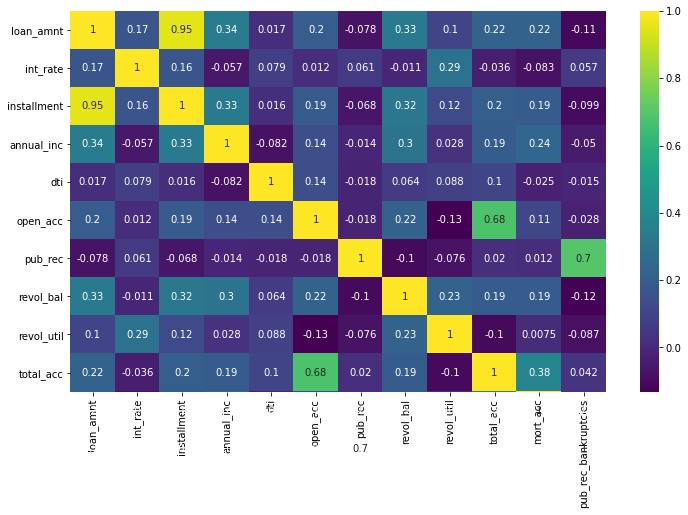

In [4]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

The monthly payment owed by the borrower if the loan originates.
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


<AxesSubplot:xlabel='installment', ylabel='loan_amnt'>

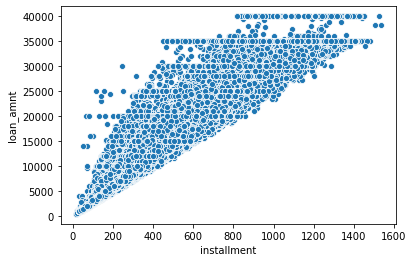

In [5]:
feat_info('installment')
feat_info('loan_amnt')
sns.scatterplot(x='installment',y='loan_amnt',data=df,)

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

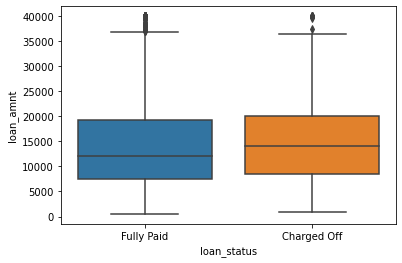

In [6]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

In [7]:
df.groupby('loan_status')['loan_amnt'].describe()



,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


<AxesSubplot:xlabel='grade', ylabel='count'>

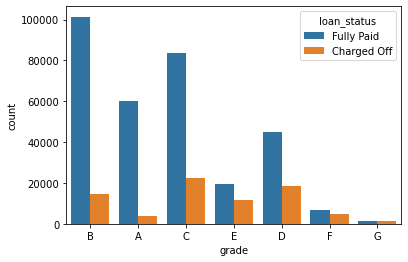

In [8]:
sorted(df['grade'].unique())
sorted(df['sub_grade'].unique())

sns.countplot(x='grade',data=df,hue='loan_status')

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

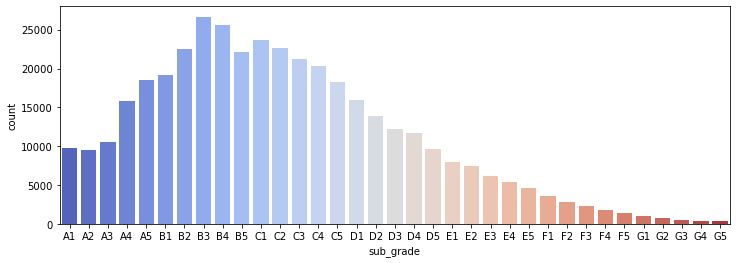

In [9]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='coolwarm' )



<AxesSubplot:xlabel='sub_grade', ylabel='count'>

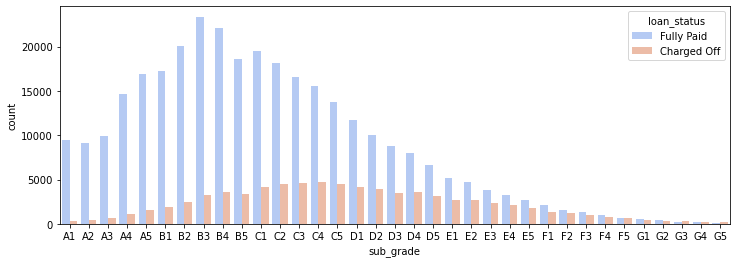

In [10]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='coolwarm' ,hue='loan_status')

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

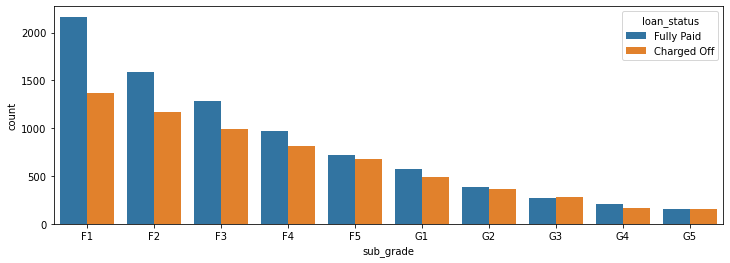

In [11]:
f_and_g = df[(df['grade']=='G') | (df['grade']=='F')]

plt.figure(figsize=(12,4))
subgrade_order = sorted(f_and_g['sub_grade'].unique())
sns.countplot(x='sub_grade',data=f_and_g,order = subgrade_order,hue='loan_status')

In [12]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

396030

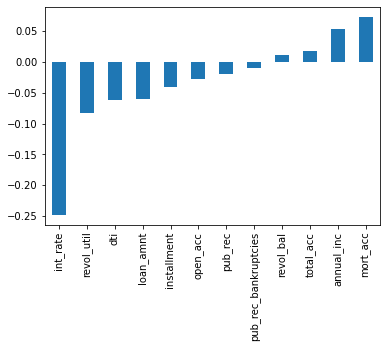

In [13]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})
df[['loan_repaid','loan_status']]


df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')
df.head()

len(df)

In [14]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [15]:
# **TASK: Convert this Series to be in term of percentage of the total DataFrame**
100* df.isnull().sum()/len(df)

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [16]:
# **TASK: Let's examine emp_title and emp_length to see whether it will be okay to drop them. Print out their feature information using the feat_info() function from the top of this notebook.**
feat_info('emp_title')
print('\n')
feat_info('emp_length')

The job title supplied by the Borrower when applying for the loan.*


Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [17]:
# **TASK: How many unique employment job titles are there?**

df['emp_title'].nunique()

df['emp_title'].value_counts()

Teacher                                 4389
Manager                                 4250
Registered Nurse                        1856
RN                                      1846
Supervisor                              1830
                                        ... 
Supervising Residential Case Manager       1
Decorator/Paint Division                   1
Whirlpool Corp                             1
colgate palmolive                          1
Soederco                                   1
Name: emp_title, Length: 173105, dtype: int64

In [18]:
# **TASK: Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.**

df = df.drop('emp_title',axis=1)

<AxesSubplot:xlabel='emp_length', ylabel='count'>

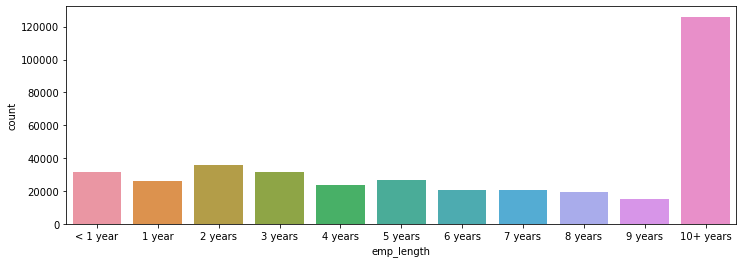

In [19]:
# **TASK: Create a count plot of the emp_length feature column. Challenge: Sort the order of the values.**

sorted(df['emp_length'].dropna().unique())

emp_length_order = [ '< 1 year',
                      '1 year',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     '10+ years']

plt.figure(figsize=(12,4))

sns.countplot(x='emp_length',data=df,order=emp_length_order)

<AxesSubplot:xlabel='emp_length'>

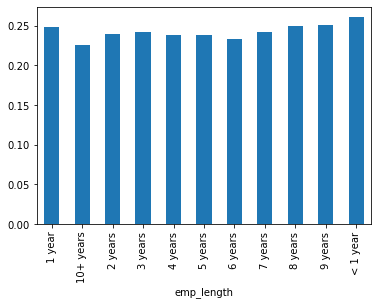

In [20]:
# **TASK: Plot out the countplot with a hue separating Fully Paid vs Charged Off**
# **CHALLENGE TASK: This still doesn't really inform us if there is a strong relationship between employment length and being charged off, what we want is the percentage of charge offs per category. Essentially informing us what percent of people per employment category didn't pay back their loan. There are a multitude of ways to create this Series. Once you've created it, see if visualize it with a [bar plot](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html). This may be tricky, refer to solutions if you get stuck on creating this Series.**

emp_co = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']

emp_fp = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']


emp_len = emp_co/emp_fp

emp_len
emp_len.plot(kind='bar')


In [21]:
# **TASK: Charge off rates are extremely similar across all employment lengths. Go ahead and drop the emp_length column.**
df = df.drop('emp_length',axis=1)

# **TASK: Revisit the DataFrame to see what feature columns still have missing data.**

df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [22]:
# **TASK: Review the title column vs the purpose column. Is this repeated information?**
df['purpose'].head(10)
df['title'].head(10)

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

In [23]:
# **TASK: The title column is simply a string subcategory/description of the purpose column. Go ahead and drop the title column.**
df = df.drop('title',axis=1)

In [24]:
# Find out what the mort_acc feature represents**
feat_info('mort_acc')

Number of mortgage accounts.


In [25]:
# **TASK: Create a value_counts of the mort_acc column.**
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

In [26]:
# **TASK: There are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or you could even bin the columns into categories and then set NaN as its own category. There is no 100% correct approach! Let's review the other columsn to see which most highly correlates to mort_acc**
print("Correlation with the mort_acc column")
df.corr()['mort_acc'].sort_values()

Correlation with the mort_acc column


int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [27]:
# **TASK: Looks like the total_acc feature correlates with the mort_acc , this makes sense! Let's try this fillna() approach. We will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry. To get the result below:**
print("Mean of mort_acc column per total_acc")
df.groupby('total_acc').mean()['mort_acc']
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

total_acc_avg[2.0]


Mean of mort_acc column per total_acc


0.0

In [28]:
def fill_mort_acc(total_acc,mort_acc):
    '''
    Accepts the total_acc and mort_acc values for the row.
    Checks if the mort_acc is NaN , if so, it returns the avg mort_acc value
    for the corresponding total_acc value for that row.
    
    total_acc_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of mort_acc per total_acc values.
    '''
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc


df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [29]:
# **TASK: revol_util and the pub_rec_bankruptcies have missing data points, but they account for less than 0.5% of the total data. Go ahead and remove the rows that are missing those values in those columns with dropna().**
df = df.dropna()
df.isnull().sum()
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [30]:
# **Let's now go through all the string features to see what we should do with them.**
#
# ### term feature
# 
# **TASK: Convert the term feature into either a 36 or 60 integer numeric data type using .apply() or .map().**
df['term'].value_counts()
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [31]:
# **TASK: We already know grade is part of sub_grade, so just drop the grade feature.**
df = df.drop('grade',axis=1)

In [32]:
# **TASK: Convert the subgrade into dummy variables. Then concatenate these new columns to the original dataframe. Remember to drop the original subgrade column and to add drop_first=True to your get_dummies call.**

# subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
# df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)
df['sub_grade'] = df['sub_grade'].apply(lambda grade: ["A", "B", "C", "D", "E", "F", "G"].index(grade[:1]) * 5 + int(grade[1:]))
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'loan_repaid'],
      dtype='object')

In [33]:
df.select_dtypes(['object']).columns

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [34]:
# ### verification_status, application_type,initial_list_status,purpose 
# **TASK: Convert these columns: ['verification_status', 'application_type','initial_list_status','purpose'] into dummy variables and concatenate them with the original dataframe. Remember to set drop_first=True and to drop the original columns.**
df['verification_status']= df['verification_status'].apply(lambda verified: 0 if verified == "Not Verified" else 1)
df['application_type']= df['application_type'].apply(lambda application: 1 if application == "JOINT" else 0)
df['initial_list_status']= df['initial_list_status'].apply(lambda status: 1 if status == "f" else 0)

dummies = pd.get_dummies(df[['purpose']],drop_first=True)
df = df.drop(['purpose'],axis=1)
# df = pd.concat([df,dummies],axis=1)

df['home_ownership'].value_counts()

df['home_ownership']= df['home_ownership'].apply(lambda ownership: 1 if ownership == "OWN" or ownership == "MORTGAGE" else 0)

In [35]:
# ### address
# **TASK: Let's feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.**
# Drop zip codes completly 
df['zip_code'] = df['address'].apply(lambda address:address[-5:])
# dummies = pd.get_dummies(df['zip_code'],drop_first=True)
# df = df.drop(['zip_code','address'],axis=1)
# df = pd.concat([df,dummies],axis=1)
df = df.drop(['zip_code','address'],axis=1)

In [36]:
# **TASK: This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.**
df = df.drop('issue_d',axis=1)

In [37]:
# ### earliest_cr_line
# **TASK: This appears to be a historical time stamp feature. Extract the year from this feature using a .apply function, then convert it to a numeric feature. Set this new data to a feature column called 'earliest_cr_year'.Then drop the earliest_cr_line feature.**

df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date:int(date[-4:]))
df = df.drop('earliest_cr_line',axis=1)

df.select_dtypes(['object']).columns

Index(['loan_status'], dtype='object')

In [38]:
# ## Train Test Split
from sklearn.model_selection import train_test_split

df = df.drop('loan_status',axis=1)

# **TASK: Set X and y variables to the .values of the features and label.**

print(df.corr()["loan_repaid"].abs().sort_values(ascending=False)[:30])
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values
print(len(df))

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

loan_repaid             1.000000
sub_grade               0.262988
int_rate                0.247826
term                    0.173374
verification_status     0.085211
revol_util              0.082296
mort_acc                0.068861
home_ownership          0.063177
dti                     0.062390
loan_amnt               0.059731
annual_inc              0.053545
installment             0.040936
earliest_cr_year        0.038907
open_acc                0.028134
pub_rec                 0.019900
total_acc               0.017852
revol_bal               0.010793
initial_list_status     0.009483
pub_rec_bankruptcies    0.009403
application_type        0.005709
Name: loan_repaid, dtype: float64
395219


In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

model = Sequential()
model.add(Dense(512,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))

# optimizer =tfa.optimizers.RectifiedAdam(lr=1e-3)
radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

model.compile(loss='binary_crossentropy', optimizer= "Adam", metrics =['accuracy', kr.f1])

class_weight= {0:1, 1:1}
with_weigths=True
if (with_weigths):
    neg, pos = np.bincount(y_train)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
    weight_for_0 = (1 / neg)*(total)/2.0
    weight_for_1 = (1 / pos)*(total)/2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x=X_train,
          y=y_train,
          epochs=30,
          class_weight=class_weight,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(monitor="val_f1", mode='max', patience=5, restore_best_weights=True)]
          )


Examples:
    Total: 316175
    Positive: 254310 (80.43% of total)

Weight for class 0: 2.56
Weight for class 1: 0.62
Epoch 1/30
1236/1236 [==============================] - 21s 17ms/step - loss: 0.6409 - accuracy: 0.6220 - f1: 0.7202 - val_loss: 0.6540 - val_accuracy: 0.5976 - val_f1: 0.6923
Epoch 2/30
1236/1236 [==============================] - 19s 16ms/step - loss: 0.6345 - accuracy: 0.6343 - f1: 0.7317 - val_loss: 0.6546 - val_accuracy: 0.5955 - val_f1: 0.6899
Epoch 3/30
1236/1236 [==============================] - 21s 17ms/step - loss: 0.6328 - accuracy: 0.6332 - f1: 0.7308 - val_loss: 0.6286 - val_accuracy: 0.6287 - val_f1: 0.7256
Epoch 4/30
1236/1236 [==============================] - 20s 16ms/step - loss: 0.6313 - accuracy: 0.6390 - f1: 0.7367 - val_loss: 0.5951 - val_accuracy: 0.6414 - val_f1: 0.7388- loss: 0.6316 - accuracy: 0.6389 -
Epoch 5/30
1236/1236 [==============================] - 19s 16ms/step - loss: 0.6305 - accuracy: 0.6441 - f1: 0.7414 - val_loss: 0.6116 - val_a

2471/2471 [==============================] - 6s 2ms/step - loss: 0.5454 - accuracy: 0.7442 - f1: 0.8340
[0.5454157590866089, 0.7442310452461243, 0.8339535593986511]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.6408873796463013, 0.6345235705375671, 0.6327553987503052, 0.6312788724899292, 0.6304882168769836, 0.6291707158088684, 0.628510057926178, 0.6278181076049805, 0.6271380186080933, 0.6269343495368958, 0.6266496777534485]


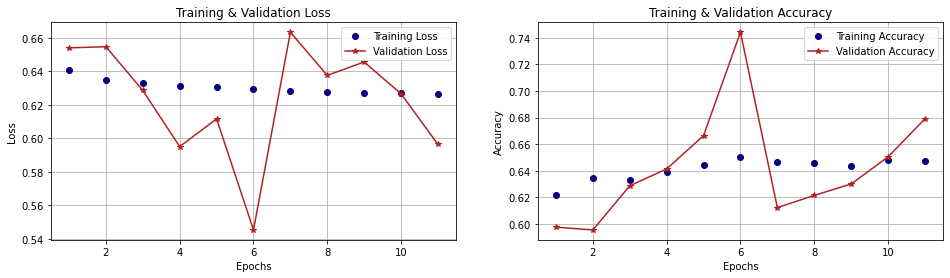

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.38      0.45      0.41     15658
           1       0.86      0.82      0.84     63386

    accuracy                           0.74     79044
   macro avg       0.62      0.63      0.62     79044
weighted avg       0.76      0.74      0.75     79044

[[ 6981  8677]
 [11540 51846]]


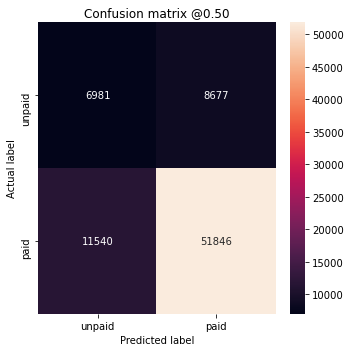

In [40]:
results = model.evaluate(X_test, y_test)
print(results)

import kr_helper_funcs as kr
from sklearn.metrics import classification_report,confusion_matrix
kr.show_plots(history.history)

predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])
plt.show()

In [41]:
# from threading import Lock
# lock = Lock()
import os
def save_model(name = 'without_postcode', model = model):
    # lock.aquire()
    # try:
    import tensorflow as tf
    if not os.path.exists(name):
        os.mkdir(name)
    tf.keras.models.save_model(model, '{}/lending-club.h5'.format(name))
    pd.DataFrame.from_dict(history.history).to_csv(name+"/"+'lending-club-history.csv'.format(name), index=False)
    np.save("{}/X_train_unscaled.npy".format(name), X_train_unscaled)
    np.save("{}/X_test_unscaled.npy".format(name), X_test_unscaled)
    np.save("{}/y_train.npy".format(name), y_train)
    np.save("{}/y_test.npy".format(name), y_test)
    df.to_csv(name+"/"+'lending-club-df.csv'.format(name), index=False)
    # finally:
    #     lock.release()
save_model()

In [42]:
# TUNE-----------------------------------------------------------------------------
stop
from ray.tune import track, tune

import tensorflow.keras as keras
from ray.tune import track
import ray
from ray import tune
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.

    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        track.log(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))


prev_eval =0

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

smte = SMOTEENN('auto')
# X_train_smte, y_train_smte = rus.fit_sample(X_train, y_train)
X_train_smte, y_train_smte = smte.fit_sample(X_train, y_train)

from threading import Lock

lock = Lock()


def create_model_tune_cofig(config):
    if config["data"] == "rus":
        X_t = X_train_rus
        y_t = y_train_rus
    elif config["data"] == "smte":
        X_t = X_train_smte
        y_t = y_train_smte
    else:
        X_t = X_train
        y_t = y_train

    create_model_tune(dense_1=int(config["dense_1"]), dense_2=int(config["dense_2"]),
                      batch_size=int(config["batch_size"]),
                      dropout=config["dropout"], optimizer_name=config["optimizer_name"], learning_rate=config["lr"],
                      X_train=X_t, y_train=y_t)

def create_model_tune(dense_1, dense_2, batch_size, dropout, optimizer_name, learning_rate, X_train=X_train, y_train=y_train):
    print ("Params : dense_1:{} dense_2:{} batch_size:{} dropout:{} optimizer_name:{} learning_rate:{}".format(dense_1, dense_2, batch_size, dropout, optimizer_name, learning_rate))
    import tensorflow as tf

    model = tf.keras.Sequential()
    model.add(Dense(dense_1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(dense_2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(78, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(39, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(19, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    if optimizer_name == 'ranger':
        radam = tfa.optimizers.RectifiedAdam(learning_rate)
        optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = 'sgd'
    # optimizer = DemonRanger(params=model.parameters())
    model.compile(loss=tf.keras.metrics.binary_crossentropy, optimizer=optimizer, metrics=[tf.keras.metrics.binary_accuracy,  kr.f1])

    # class_weight = {0: 1, 1: 1}
    neg, pos = np.bincount(y_train)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    weight_for_0 = (1 / neg) * (total) / 2.0
    weight_for_1 = (1 / pos) * (total) / 2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

    # early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(x=X_train,
              y=y_train,
              epochs=30,
              class_weight=class_weight,
              batch_size=batch_size,
              validation_data=(X_test, y_test),
              callbacks=[EarlyStopping(monitor="val_f1", mode='max', patience=5, restore_best_weights=True),
                         TuneReporterCallback()]
              )

hyperparameter_space = {
    "dense_1": tune.sample_from(list([256, 512])),
    "dense_2": tune.sample_from(list([90, 128])), # there are 3 other hardcoded layers after this one
    "batch_size": tune.sample_from(list([64, 256, 512, 1024])),
    "dropout": tune.sample_from(list([0.2, 0.5])),
    "optimizer_name": tune.sample_from(list(["adam", "ranger", "sgd"])),
    "lr": tune.sample_from(list([0.001, 0.1])),
    "data": tune.sample_from(list(["default", "rus", "smte"]))
}

num_samples = 4
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost.
ray.init(num_cpus=8, memory=10000000000, log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
# ! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    create_model_tune_cofig,
    verbose=1,
    config=hyperparameter_space,
    num_samples=num_samples)

NameError: name 'stop' is not defined